In [1]:
import function.functions as functions
# import function.functions_nocuda as functions # use this if you can't use cuda and the GPU

from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['text.usetex'] = True
params = {
    "backend": "ps",
    "axes.labelsize": 22,
    "font.size": 22,
    "legend.fontsize": 10,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    "legend.frameon": True,
    "savefig.dpi": 100,
    "axes.linewidth": 1.5,
    'xtick.major.size' : 10,
    'xtick.major.width': 1,
    'xtick.minor.size': 7,
    'xtick.minor.width': 1,
    'ytick.major.size' : 10,
    'ytick.major.width': 1,
    'ytick.minor.size': 7,
    'ytick.minor.width': 1,
    'axes.xmargin' : 0,
    'axes.ymargin' : 0,
}
plt.rcParams.update(params)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('text', usetex=True)

In [2]:
# Set device and parameters in this part

############################# Set parameters ##############################
device = 'charge_qubit' # change here to change the device: charge_qubit, flopping_spin, flopping_charge, transmon, fluxonium

data = np.load('data/params/'+device+'.npz', allow_pickle=True)
H_sys, drive_op, wq, g, kappa, num_A, dim = data['H_sys'], data['drive_op'], data['wq'], data['g'], data['kappa'], data['num_A'], data['dim']
#############################################################################

if device == 'charge_qubit':
    dim = 2
    n_states = 2
    num_w = 151
    N_rep = 40

    Alist_cut_SNR = np.linspace(0,1*wq,40)
    N_fock = 10

    proj = None
    
    compensation = False # set compensation True/False
    
else:
    print('device not implemented in this notebook')
    sys.exit()

ground, excited = 0, 1

qubit_state_list = [ground, excited]

final_t = 0.2

tlist = np.linspace(0,final_t/kappa,num=100)

H_sys = Qobj(H_sys[0:n_states,0:n_states]) # truncation
drive_op = Qobj(drive_op[0:n_states,0:n_states]) # truncation
###########################################################################

########################## Import data ####################################
fname_import ='data/'+device+'/SNR_params_and_analytics_N_rep='+str(N_rep)+'_n_states='+str(n_states)+'_dim='+str(dim)+'_num_w='\
    +str(num_w)+'_final_t='+str(final_t)+'_compensation='+str(compensation)

def import_npz(npz_file):
    Data = np.load(npz_file, allow_pickle=True)
    for varName in Data:
        globals()[varName] = Data[varName]

import_npz(fname_import+'.npz')
###############################################################################

########################### Custom parameters #################################
# test other parameters Alist_cut_SNR, wlist

save_file = True # test mode or save data to generate the data of the figure of the paper
################################################################################

In [3]:
list_index_wr = [index_wr_low,index_wr_high]

res_num_cut_SNR = np.zeros((len(Alist_cut_SNR),2), dtype=object)
res_an_cut_SNR= np.zeros((len(Alist_cut_SNR),2), dtype=object)

wlist_cut_SNR = [wlist[list_index_wr[0]], wlist[list_index_wr[1]]]

if save_file:
    fname = 'data/'+device+'/SNR_cut_N_fock='+str(N_fock)+'_N_rep='+str(N_rep)+'_num_w='+str(num_w)+'_final_t='+str(final_t)

    data = open(fname+'.txt',"w")
    data.close()

else:
    fname = None

A_list, dd_real, dd2_real, z0 = functions.get_derivatives(N_rep,Alist_cut_SNR,H_sys,drive_op,wlist_cut_SNR,n_states,num_A,fname,True,qubit_state_list)
    
for j, w_r in enumerate(wlist_cut_SNR):        
    for i, A_q in enumerate(Alist_cut_SNR):
        index_A = i

        g1 = g*dd_real[j,index_A,excited]
        g0 = g*dd_real[j,index_A,ground]

        chi1 = g**2*(dd2_real[j,index_A,excited]+1/A_q*dd_real[j,index_A,excited])
        chi0 = g**2*(dd2_real[j,index_A,ground]+1/A_q*dd_real[j,index_A,ground])

        g_parallel = 1/2*(g1-g0)
        chi = 1/2*(chi1-chi0)

        g_sum = 1/2*(g1+g0)
        chi_sum = 1/2*(chi1+chi0)

        if(compensation):
            w_d = w_r+chi_sum # shifted resonator frequency
            A_d = -2*g_sum # compensation tone
        else:
            w_d = w_r
            A_d = 0
        
        res_a_an = [[],[]]

        gamma = kappa*(g/(wq-w_r))**2 # Purcell

        numerical_result, exp_fock, exp_proj = functions.real_time_dynamics(H_sys,A_q,np.array([A_d]),[w_r],[w_d],0,g,drive_op,n_states,kappa,qubit_state_list,tlist,N_fock,proj,fname)

        res_a_num = [numerical_result[0,0], numerical_result[0,1]]

        for idx, qubit_state in enumerate(qubit_state_list):

            analytical_result = functions.analytical_time_dynamics(z0[j,i,idx],w_r,w_d,A_d,0,g_parallel,g_sum,chi,chi_sum,kappa,gamma,tlist)

            res_a_an[idx].append(analytical_result)
        
        res_num_cut_SNR[i,j] = functions.generate_SNR_list(res_a_num,kappa,tlist)[-1]
        res_an_cut_SNR[i,j] = functions.generate_SNR_list(res_a_an,kappa,tlist)[-1]

CUDARuntimeError: cudaErrorUnknown: unknown error

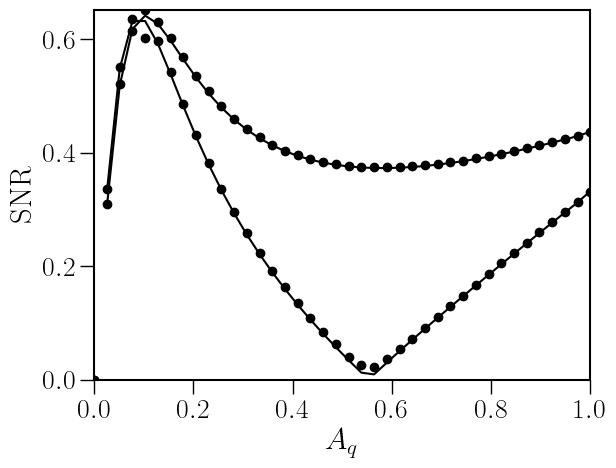

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for j, w_r in enumerate(wlist_cut_SNR):    
    ax.plot(Alist_cut_SNR, res_an_cut_SNR[:,j], c='black')
    ax.scatter(Alist_cut_SNR, res_num_cut_SNR[:,j], marker='o', c='black')

ax.set_xlabel(r'$A_q$')
ax.set_ylabel('SNR')

plt.show()

In [ ]:
if save_file:
    np.savez(fname, wlist_cut_SNR=wlist_cut_SNR, Alist_cut_SNR=Alist_cut_SNR, res_an_cut_SNR=res_an_cut_SNR, res_num_cut_SNR=res_num_cut_SNR, z0=z0, final_t=final_t)